In [3]:

import os
import torch
import argparse
import itertools
import numpy as np
from tqdm import tqdm
from urllib.request import urlopen
from PIL import Image
import timm
from torch import Tensor
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
from glob import glob
from sklearn.model_selection import train_test_split
import torch.nn as nn
import random
from torch.nn.modules.batchnorm import _BatchNorm
import torchmetrics
import matplotlib.pyplot as plt
import torch.nn.functional as F
print(f"GPUs used:\t{torch.cuda.device_count()}")
device = torch.device("cuda",0)
print(f"Device:\t\t{device}")

GPUs used:	1
Device:		cuda:0


In [4]:

class_list=['BRNT','BRID','BRIL','BRLC','BRDC']
params={'image_size':512,
        'lr':2e-4,
        'beta1':0.5,
        'beta2':0.999,
        'batch_size':8,
        'epochs':1000,
        'n_classes':5,
        'data_path':'../../data/NIPA/',
        'inch':3,
        }
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# 새로운 셀에 추가해서 테스트해보세요
import torch.nn as nn

# 1. BatchNorm 상태 확인
def check_batchnorm_stats(model):
    """BatchNorm 레이어의 running_mean과 running_var 확인"""
    for name, module in model.named_modules():
        if isinstance(module, nn.BatchNorm2d):
            if torch.isnan(module.running_mean).any() or torch.isnan(module.running_var).any():
                print(f"NaN detected in {name}")
                print(f"Running mean has NaN: {torch.isnan(module.running_mean).any()}")
                print(f"Running var has NaN: {torch.isnan(module.running_var).any()}")

# 2. BatchNorm 초기화 함수
def reset_batchnorm_stats(model):
    """BatchNorm의 running statistics 초기화"""
    for module in model.modules():
        if isinstance(module, nn.BatchNorm2d):
            module.reset_running_stats()

# 3. 안전한 eval 모드 설정
def safe_eval_mode(model):
    """안전하게 eval 모드로 전환"""
    model.eval()
    # BatchNorm 레이어의 momentum을 원래대로 복구
    for module in model.modules():
        if isinstance(module, nn.BatchNorm2d) and hasattr(module, 'backup_momentum'):
            module.momentum = module.backup_momentum



In [5]:

trans = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

def transback(data:Tensor) -> Tensor:
    return data / 2 + 0.5

class CustomDataset(Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self,parmas, images,label):
        
        self.images = images
        self.args=parmas
        self.label=label
        
    def trans(self,image):
        if random.random() > 0.5:
            transform = transforms.RandomHorizontalFlip(1)
            image = transform(image)
            
        if random.random() > 0.5:
            transform = transforms.RandomVerticalFlip(1)
            image = transform(image)
            
        return image
    
    def __getitem__(self, index):
        image=self.images[index]
        label=self.label[index]
        image = self.trans(image)
        return image,label
    
    def __len__(self):
        return len(self.images)


image_label=[]
image_path=[]
for i in tqdm(range(len(class_list))):
    image_list=glob(params['data_path']+class_list[i]+'/*.jpeg')
    for j in range(len(image_list)):
        image_path.append(image_list[j])
        image_label.append(i)
        
train_images=torch.zeros((len(image_path),params['inch'],params['image_size'],params['image_size']))
for i in tqdm(range(len(image_path))):
    train_images[i]=trans(Image.open(image_path[i]).convert('RGB').resize((params['image_size'],params['image_size'])))
X_train, X_test, y_train, y_test = train_test_split(train_images, image_label, test_size=0.2, random_state=42)
# train_dataset=CustomDataset(params,X_train,F.one_hot(torch.tensor(y_train)).to(torch.int64))
train_dataset=CustomDataset(params,train_images,F.one_hot(torch.tensor(image_label)).to(torch.int64))
val_dataset=CustomDataset(params,X_test,F.one_hot(torch.tensor(y_test)).to(torch.int64))
dataloader=DataLoader(train_dataset,batch_size=params['batch_size'],shuffle=True)
val_dataloader=DataLoader(val_dataset,batch_size=1,shuffle=True)

100%|██████████| 10625/10625 [04:02<00:00, 43.85it/s]


In [6]:
class FeatureExtractor(nn.Module):
    """Feature extoractor block"""
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        cnn1= timm.create_model('tf_efficientnetv2_xl', pretrained=True)
        self.feature_ex = nn.Sequential(*list(cnn1.children())[:-1])

    def forward(self, inputs):
        features = self.feature_ex(inputs)
        
        return features
class custom_model(nn.Module):
    def __init__(self, num_classes, image_feature_dim,feature_extractor_scale1: FeatureExtractor):
        super(custom_model, self).__init__()
        self.num_classes = num_classes
        self.image_feature_dim = image_feature_dim

        # Remove the classification head of the CNN model
        self.feature_extractor = feature_extractor_scale1
        # Classification layer
        self.classification_layer = nn.Linear(image_feature_dim, num_classes)
        
    def forward(self, inputs):
        batch_size, channels, height, width = inputs.size()
        
        # Feature extraction using the pre-trained CNN
        features = self.feature_extractor(inputs)  # Shape: (batch_size, 2048, 1, 1)
        
        # Classification layer
        logits = self.classification_layer(features)  # Shape: (batch_size, num_classes)
        
        return logits
    
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
        self.defaults.update(self.base_optimizer.defaults)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups
        
def disable_running_stats(model):
    def _disable(module):
        if isinstance(module, _BatchNorm):
            module.backup_momentum = module.momentum
            module.momentum = 0

    model.apply(_disable)

def enable_running_stats(model):
    def _enable(module):
        if isinstance(module, _BatchNorm) and hasattr(module, "backup_momentum"):
            module.momentum = module.backup_momentum
            
import transformers

Feature_Extractor=FeatureExtractor()
model = custom_model(len(class_list),1280,Feature_Extractor)
model = model.to(device)
base_optimizer = torch.optim.AdamW
optimizer = SAM(model.parameters(), base_optimizer, lr=params['lr'])
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=len(class_list)).to(device)
model.load_state_dict(torch.load('../../model/NIPA_classification/Breast/modelEff_v2_XL_SAM_244.pt'))

<All keys matched successfully>

In [ ]:
MIN_loss=5000
train_loss_list=[]
val_loss_list=[]
sig=nn.Sigmoid()
model_path='../../model/NIPA_classification/Breast/'
create_dir(model_path)
val_acc_list=[]
for epoch in range(1000):
    train=tqdm(dataloader)
    count=0
    running_loss = 0.0
    acc_loss=0
    model.train()
    for x, y in train:
        
        y = y.to(device).float()
        count+=1
        x=x.to(device).float()
        enable_running_stats(model)
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device)
        cost = F.cross_entropy(predict, y) # cost 구함
        cost.backward() # cost에 대한 backward 구함
        optimizer.first_step(zero_grad=True)
        disable_running_stats(model)
        predict = model(x).to(device)
        cost1 = F.cross_entropy(predict, y) # cost 구함
        cost1.backward() # cost에 대한 backward 구함
        optimizer.second_step(zero_grad=True)
        running_loss += cost.item()

        train.set_description(f"epoch: {epoch+1}/{1000} Step: {count+1} loss : {running_loss/count:.4f}")
    train_loss_list.append((running_loss/count))
#validation
    val=tqdm(val_dataloader)
    count=0
    val_running_loss=0.0
    acc_loss=0
    with torch.no_grad():
        for x, y in val:
            y = y.to(device).float()
            count+=1
            x=x.to(device).float()
            predict = model(x).to(device)
            cost = F.cross_entropy(predict, y) # cost 구함
            acc=accuracy(predict.argmax(dim=1),y.argmax(dim=1))
            val_running_loss+=cost.item()
            acc_loss+=acc
            val.set_description(f"Validation epoch: {epoch+1}/{1000} Step: {count+1} loss : {val_running_loss/count:.4f}  accuracy: {acc_loss/count:.4f}")
        val_loss_list.append((val_running_loss/count))
        val_acc_list.append((acc_loss/count).cpu().detach().numpy())
    if epoch%100==5:
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')

        plt.legend()
        plt.subplot(1, 2, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),val_acc_list,label='validation_acc')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')

        plt.legend()
        plt.show()
        
        
    if MIN_loss>(val_running_loss/count):
        torch.save(model.state_dict(), f'{model_path}modelEff_v2_XL_SAM_'+str(epoch)+'.pt')
        MIN_loss=(val_running_loss/count)
torch.save(model.state_dict(), f'{model_path}modelEff_v2_XL_SAM.pt')

Evaluating on Test Set...


Testing: 100%|██████████| 266/266 [00:13<00:00, 19.81it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len


📊 Test Set Performance Results
Overall Accuracy: 0.3798 (37.98%)
Macro Average - Precision: 0.3476, Recall: 0.2635, F1-Score: 0.2037
Weighted Average - Precision: 0.3632, Recall: 0.3798, F1-Score: 0.2495

📋 Per-Class Performance:
----------------------------------------------------------------------
Class  Precision  Recall  F1-Score  Support
 BRNT     0.3593  1.0000    0.5286      711
 BRID     0.0000  0.0000    0.0000      490
 BRIL     0.0000  0.0000    0.0000      232
 BRLC     0.5341  0.2136    0.3052      220
 BRDC     0.8448  0.1038    0.1849      472

🔄 Confusion Matrix:
------------------------------
      BRNT  BRID  BRIL  BRLC  BRDC
BRNT   711     0     0     0     0
BRID   461     0     0    23     6
BRIL   230     0     0     1     1
BRLC   171     0     0    47     2
BRDC   406     0     0    17    49


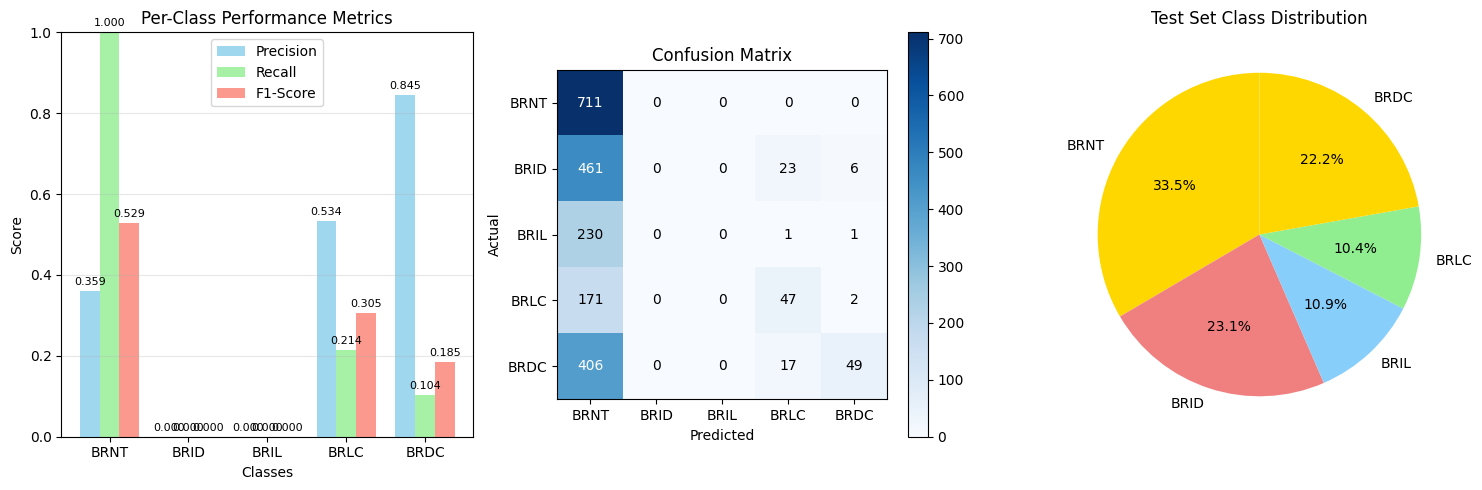


📝 Summary for Paper:
The stomach classification model achieved an overall accuracy of 0.3798 on the test set.
The macro-averaged F1-score was 0.2037, indicating poor performance across all classes.
Best performing class: BRNT (F1-Score: 0.5286)
Most challenging class: BRID (F1-Score: 0.0000)

💾 Results saved to:
  - Per-class results: ../../model/NIPA_classification/Breast/per_class_results.csv
  - Overall results: ../../model/NIPA_classification/Breast/overall_results.csv
  - Confusion matrix: ../../model/NIPA_classification/Breast/confusion_matrix.csv

📈 Additional Statistics:
--------------------------------------------------
Total test samples: 2125
Class distribution: {'BRNT': 711, 'BRID': 490, 'BRIL': 232, 'BRLC': 220, 'BRDC': 472}
Standard deviation of F1-scores: 0.1996
95% Confidence Interval for accuracy: [0.3591, 0.4004]


In [ ]:
# Test Set Performance Evaluation
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import matplotlib
model_path='../../model/NIPA_classification/Breast/'
matplotlib.rcParams['font.size'] = 10
X_train, X_test, y_train, y_test = train_test_split(train_images, image_label, test_size=0.2, random_state=41)
train_dataset=CustomDataset(params,X_train,F.one_hot(torch.tensor(y_train)).to(torch.int64))
val_dataset=CustomDataset(params,X_test,F.one_hot(torch.tensor(y_test)).to(torch.int64))
dataloader=DataLoader(train_dataset,batch_size=params['batch_size'],shuffle=True)
val_dataloader=DataLoader(val_dataset,batch_size=params['batch_size'],shuffle=True)
# Load the best model
best_model_path = f'{model_path}modelEff_v2_XL_SAM_244.pt'
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Test set evaluation
test_predictions = []
test_labels = []
test_probabilities = []

print("Evaluating on Test Set...")
print("="*50)

with torch.no_grad():
    for x, y in tqdm(val_dataloader, desc="Testing"):
        x = x.to(device).float()
        y = y.to(device).float()
        
        outputs = model(x)
        probabilities = F.softmax(outputs, dim=1)
        predictions = torch.argmax(probabilities, dim=1)
        
        test_predictions.extend(predictions.cpu().numpy())
        test_labels.extend(torch.argmax(y, dim=1).cpu().numpy())
        test_probabilities.extend(probabilities.cpu().numpy())

# Convert to numpy arrays
test_predictions = np.array(test_predictions)
test_labels = np.array(test_labels)
test_probabilities = np.array(test_probabilities)

# Calculate metrics
accuracy = accuracy_score(test_labels, test_predictions)
precision, recall, f1, support = precision_recall_fscore_support(test_labels, test_predictions, average=None)
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='macro')
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='weighted')

# Create results table
results_df = pd.DataFrame({
    'Class': class_list,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support.astype(int)
})

print("\n📊 Test Set Performance Results")
print("="*50)
print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Macro Average - Precision: {macro_precision:.4f}, Recall: {macro_recall:.4f}, F1-Score: {macro_f1:.4f}")
print(f"Weighted Average - Precision: {weighted_precision:.4f}, Recall: {weighted_recall:.4f}, F1-Score: {weighted_f1:.4f}")

print("\n📋 Per-Class Performance:")
print("-"*70)
print(results_df.round(4).to_string(index=False))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_predictions)
cm_df = pd.DataFrame(cm, index=class_list, columns=class_list)

print("\n🔄 Confusion Matrix:")
print("-"*30)
print(cm_df.to_string())

# Visualization with matplotlib only (avoiding seaborn compatibility issues)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Subplot 1: Per-class metrics
ax1 = axes[0]
x_pos = np.arange(len(class_list))
width = 0.25

bars1 = ax1.bar(x_pos - width, precision, width, label='Precision', alpha=0.8, color='skyblue')
bars2 = ax1.bar(x_pos, recall, width, label='Recall', alpha=0.8, color='lightgreen')
bars3 = ax1.bar(x_pos + width, f1, width, label='F1-Score', alpha=0.8, color='salmon')

ax1.set_xlabel('Classes')
ax1.set_ylabel('Score')
ax1.set_title('Per-Class Performance Metrics')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(class_list)
ax1.legend()
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Subplot 2: Confusion Matrix Heatmap using matplotlib
ax2 = axes[1]
im = ax2.imshow(cm, cmap='Blues', interpolation='nearest')
ax2.set_title('Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

# Add colorbar
cbar = plt.colorbar(im, ax=ax2)

# Add text annotations
for i in range(len(class_list)):
    for j in range(len(class_list)):
        text = ax2.text(j, i, str(cm[i, j]),
                       ha="center", va="center", color="white" if cm[i, j] > cm.max()/2 else "black")

ax2.set_xticks(range(len(class_list)))
ax2.set_yticks(range(len(class_list)))
ax2.set_xticklabels(class_list)
ax2.set_yticklabels(class_list)

# Subplot 3: Class Distribution
ax3 = axes[2]
unique, counts = np.unique(test_labels, return_counts=True)
class_names = [class_list[i] for i in unique]
colors = ['gold', 'lightcoral', 'lightskyblue', 'lightgreen'][:len(class_names)]
wedges, texts, autotexts = ax3.pie(counts, labels=class_names, autopct='%1.1f%%', 
                                   startangle=90, colors=colors)
ax3.set_title('Test Set Class Distribution')

plt.tight_layout()
plt.show()

# Summary for paper
print("\n📝 Summary for Paper:")
print("="*50)
print(f"The stomach classification model achieved an overall accuracy of {accuracy:.4f} on the test set.")
print(f"The macro-averaged F1-score was {macro_f1:.4f}, indicating {['poor', 'fair', 'good', 'excellent'][min(3, int(macro_f1*4))]} performance across all classes.")

# Individual class performance summary
best_class = class_list[np.argmax(f1)]
worst_class = class_list[np.argmin(f1)]
print(f"Best performing class: {best_class} (F1-Score: {f1[np.argmax(f1)]:.4f})")
print(f"Most challenging class: {worst_class} (F1-Score: {f1[np.argmin(f1)]:.4f})")

# Export results to CSV for paper
results_summary = {
    'Metric': ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1-Score', 
               'Weighted Precision', 'Weighted Recall', 'Weighted F1-Score'],
    'Value': [accuracy, macro_precision, macro_recall, macro_f1, 
              weighted_precision, weighted_recall, weighted_f1]
}

summary_df = pd.DataFrame(results_summary)
results_df.to_csv(f'{model_path}per_class_results.csv', index=False)
summary_df.to_csv(f'{model_path}overall_results.csv', index=False)
cm_df.to_csv(f'{model_path}confusion_matrix.csv')

print(f"\n💾 Results saved to:")
print(f"  - Per-class results: {model_path}per_class_results.csv")
print(f"  - Overall results: {model_path}overall_results.csv")
print(f"  - Confusion matrix: {model_path}confusion_matrix.csv")

# Additional statistics for paper
print(f"\n📈 Additional Statistics:")
print("-"*50)
print(f"Total test samples: {len(test_labels)}")
print(f"Class distribution: {dict(zip(class_list, [support[i] for i in range(len(class_list))]))}")
print(f"Standard deviation of F1-scores: {np.std(f1):.4f}")
print(f"95% Confidence Interval for accuracy: [{accuracy - 1.96*np.sqrt(accuracy*(1-accuracy)/len(test_labels)):.4f}, {accuracy + 1.96*np.sqrt(accuracy*(1-accuracy)/len(test_labels)):.4f}]")